In [1]:
'''
Demos written and developed by: Andrew E. Oriani 2020 EMAIL: oriani@uchicago.edu

'''
from PyInventor import *
import numpy as np
from numpy import pi, cos, sin, sqrt, log
import math
import glob
import time
import datetime


#Import plotting libraries for later
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib import cm
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm 
from matplotlib.ticker import MaxNLocator

import pandas as pd

import pyEPR
from pyEPR import ansys as HFSS
from pyEPR.core_distributed_analysis import CalcObject

import scipy
from scipy import constants as const
import scipy.optimize
import scipy.interpolate

from pint import UnitRegistry
ureg = UnitRegistry()
Q = ureg.Quantity
import os
import re as regex

# Field integrals code
import sys
sys.path.append('../python/src')
import field_integrals as fint

C:\Users\materise1\AppData\Local\anaconda3\envs\tcav\Lib\site-packages\pyepr_quantum-0.9.0-py3.12.egg\pyEPR\ansys.py:82: SyntaxWarning: invalid escape sequence '\d'
C:\Users\materise1\AppData\Local\anaconda3\envs\tcav\Lib\site-packages\pyepr_quantum-0.9.0-py3.12.egg\pyEPR\ansys.py:1583: SyntaxWarning: invalid escape sequence '\$'
C:\Users\materise1\AppData\Local\anaconda3\envs\tcav\Lib\site-packages\pyepr_quantum-0.9.0-py3.12.egg\pyEPR\ansys.py:82: SyntaxWarning: invalid escape sequence '\d'
C:\Users\materise1\AppData\Local\anaconda3\envs\tcav\Lib\site-packages\pyepr_quantum-0.9.0-py3.12.egg\pyEPR\ansys.py:1583: SyntaxWarning: invalid escape sequence '\$'


# Driven Modal

In [2]:
'''
Driven Modal Simulation Driver

This sets up a standard eigenmode simulation without the qubit, just the bare cavity created above. It calculates
the mode frequencies, loss (with boundary impedances set) and the electric and magnetic surface participation 
ratios (S_e, S_m)

'''

overwrite = False
solution_type = 'driven_modal'
ref_name = 'two_post_leaf_spring_gaps'
project_name=f'{ref_name}'
design_name=f'two_post_leaf_spring_jj_bbq'

#use file location path:
HFSS_path=os.getcwd()

full_path=HFSS_path+'\\HFSS\\'+project_name+'.aedt'

HFSS_app=HFSS.HfssApp()
HFSS_desktop=HFSS_app.get_app_desktop()

project=HFSS_desktop.open_project(full_path)

if project==None:
    project=HFSS_desktop.new_project()
    project.save(full_path)
    
project.save(full_path)
project.make_active()
    
if design_name in project.get_design_names():
    if overwrite==True:
        project.delete_design(design_name)
        project.save()
        
        # Setup a driven modal design type
        if solution_type == 'driven_modal':
            EM_design=project.new_dm_design(design_name)
        elif solution_type == 'eigenmode':
            EM_design=project.new_em_design(design_name)
        else:
            raise ValueError(f'Solution type ({solution_type}) not recognized.')
    else:
        EM_design=project.get_design(design_name)
        
else:
    if solution_type == 'driven_modal':
        EM_design=project.new_dm_design(design_name)
    elif solution_type == 'eigenmode':
        EM_design=project.new_em_design(design_name)
    else:
        raise ValueError(f'Solution type ({solution_type}) not recognized.')
        
EM_design.make_active()
model=HFSS.HfssModeler(EM_design)

project=HFSS_desktop.open_project(full_path)

if project==None:
    project=HFSS_desktop.new_project()
    project.save(full_path)
    
project.make_active()
    
if design_name in project.get_design_names():
    if overwrite==True:
        project.delete_design(design_name)
        project.save()
        EM_design=project.new_em_design(design_name)
    else:
        EM_design=project.get_design(design_name)
        
else:
    EM_design=project.new_em_design(design_name)
        
EM_design.make_active()
model=HFSS.HfssModeler(EM_design)

project_name: two_post_leaf_spring_gaps
path: C:\Users\materise1\tcav\ipynbs\HFSS\two_post_leaf_spring_gaps.aedt
project_name: two_post_leaf_spring_gaps
path: C:\Users\materise1\tcav\ipynbs\HFSS\two_post_leaf_spring_gaps.aedt


## Interpolating sweep to identify resonances

In [ ]:
f1 = 2; f2 = 15.; count = 20001

# Define the sweep range
DM_setup = None
if not DM_setup:
    DM_setup = EM_design.create_dm_setup()
    

In [ ]:
DM_setup.insert_sweep(f1, f2, count=count, save_fields=False, name='Interpolating_0', type='Interpolating')

In [ ]:
DM_setup.solve()

In [2]:
def set_axes_fonts(ax, fsize):
    """
    Set axes font sizes because it should be abstracted away
    """
    for tick in ax.get_xticklabels():
        tick.set_fontsize(fsize)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(fsize)

def set_xaxis_rot(ax, angle=45):
    """
    Rotate the x-axis labels
    """
        
    for tick in ax.get_xticklabels():
        tick.set_rotation(angle)

def set_leg_outside(ax, fsize):
    """
    Sets the legend location outside
    """
    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    # Put a legend to the right of the current axis
    hdls, legs = ax.get_legend_handles_labels()
    leg = ax.legend(hdls, legs, loc='center left', bbox_to_anchor=(1, 0.5), \
                    fontsize=fsize, framealpha=0.)

    return leg

In [3]:
def plot_2d_cmap(x, y, z, fname,                                                
                 xstr='', ystr='',                                              
                 tstr='', cbar_str='',                                          
                 cmap=cm.viridis,
                 xyscales={'x' : 'linear', 'y': 'linear'},
                 interp_zeros=False,
                interp_std_dev=10,
                image_rot_angle=0,
                xrot_angle=None,
                norm_type='linear',
                zref=None, 
                fsize=30,
                tsize=36):
    """                                                                         
    Plot 2D colormap data such that                                             
                                                                                
         -----------------------                                                
         |                     |                                                
         |                     |                                                
    y    |          z          |                                                
         |                     |                                                
         |                     |                                                
         -----------------------                                                
                                                                                
                    x                                                           
                                                                                
    Parameters:                                                                 
    ----------                                                                  
                                                                                
    x, y:       independent variables                                           
    z:          resulting data, z = z(x, y)                                     
    fname:      output figure filename, relative path with file extension       
    xstr:       x-axis label                                                    
    ystr:       y-axis label                                                    
    tstr:       title label                                                     
    cbar_str:   lable for color bar                                             
    cmap:       colormap to use on the 2D figure output                         
                                                                                
    """
    # Interpolate the data
    if interp_zeros:
        hot_pixels, z = fix_outlier_pixels(z, tolerance=interp_std_dev)
    
    # Setup the color map, normalizations, etc
    if norm_type == 'linear':
        norm = mpl.colors.Normalize(z.min(), z.max())
    elif norm_type == 'log':
        if zref:
            norm = mpl.colors.LogNorm(min(zref), max(zref))
        else:
            norm = mpl.colors.Normalize(min(zref), max(zref))    
    elif (norm_type == 'ref') and zref:
        norm = mpl.colors.Normalize(min(zref), max(zref))
    else:
        raise ValueError(f'norm_type ({norm_type}) not recognized')                                         
                                                                                
    # Setup the figure and axes                                                 
    fig, ax = plt.subplots(1, 1, figsize=(10, 8), tight_layout=True)
    
    # Set the scale bar and levels
    if (norm_type == 'ref') and zref:
        levels = MaxNLocator(nbins=20).tick_values(min(zref), max(zref))
    else:
        levels = MaxNLocator(nbins=20).tick_values(z.min(), z.max())
    if image_rot_angle:
        z = scipy.ndimage.rotate(z, image_rot_angle, reshape=True)
    #plt1 = ax.imshow(z, cmap=cmap, norm=norm)
    plt1 = ax.pcolormesh(x, y, z, cmap=cmap, norm=norm)
    ax.set_xlabel(xstr, fontsize=fsize)                                         
    ax.set_ylabel(ystr, fontsize=fsize)                                         
    ax.set_title(tstr, fontsize=tsize)
    
    # Rotate the xlabels. Set both x and y labels to headers[1:]
    ax.set_xscale(xyscales['x'])
    ax.set_yscale(xyscales['y'])
    if xrot_angle is not None:
        set_xaxis_rot(ax, xrot_angle)
                                                                                
    # Set the axis tick labels to a reasonable size                             
    set_axes_fonts(ax, fsize)                                                   
                                                                                
    # Set the color bar, offset the title slightly from top                     
    cbar = fig.colorbar(plt1, ax=ax)                                            
    cbar.ax.set_title(cbar_str, fontsize=fsize, y=1.025)                        
    cbar.ax.tick_params(labelsize=fsize)                                        
                                                                                
    # Write the results to file
    print(f'Writing {fname} ...')
    fig.savefig(fname, format='pdf', transparent=True)                  

### Get the interpolating sweep data to estimate resonance positions

In [ ]:
fsweep_interp = HFSS.HfssFrequencySweep(DM_setup, 'Interpolating_0')

report_im = fsweep_interp.create_report('Interpolating_0', expr='im(Y(LumpPort,LumpPort))')
yim = report_im.get_arrays()

In [ ]:
# Identify the zero crossings as resonances
zero_xing_idxs = np.where(np.diff(np.sign(yim[1,:])) > 0)[0]
resonances = yim[0,zero_xing_idxs]

print(f'resonances: {resonances}')

In [ ]:
# Plot the results, save the figure(s)
fsize = 20
fscale = 1e9
#wp, Lp, Cp, Qp, fcpy, ycpy, yp, pl, pc, gD, chippp = \
#get_wp_Cp_Lp(fdata, ydata, LJ0=None, CJ0=None, fscale=1e9, use_Zq=False)
%matplotlib inline
fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.plot(yim[0,:], yim[1,:], '.-', label='Zero Crossings')
ax.plot(resonances,
        yim[1,zero_xing_idxs],
        'o', label='Zero Crossings')
# ax.set_xlim([5.28, 5.3])
ax.set_ylim([-0.01, 0.01])
ax.axhline(y=0, ls='--', color='k')
# ax.plot(fdata, ydata.imag)
set_xaxis_rot(ax, 45)
ax.set_ylabel(r'Im $Y(\omega)$', fontsize=fsize)
ax.set_xlabel(r'Frequency [GHz]', fontsize=fsize)
set_axes_fonts(ax, fsize)

In [ ]:
resonances
# [9.087715 9.66241 ]

#### Bypass the interpolating sweep if frequencies already known

In [ ]:
# resonances = np.array([ 6.0928,  6.1684,  6.1692,  6.2692,  7.3356,  7.3816,  7.4712,
#        7.506 ,  9.3064,  9.3292,  9.588 ,  9.6076, 11.5804, 11.6684,
#       11.7568, 11.95  , 12.604 , 12.6944, 12.8012, 12.8048])
# resonances = np.array([ 6.0928,  6.1692,  6.2692,  7.3816,  7.4712,
#        7.506 , 9.3292,  9.588 ,  9.6076, 11.5804, 
#       11.7568, 11.95, 12.6944, 12.8048])

# Use half the minimum spacing between resonances as a the bandwidth
#Nmodes = 10
idxs = [0, 1]
resonances = resonances[idxs]
df = 0.8 * np.diff(np.hstack((f1, resonances, f2))).min()

In [ ]:
df

In [ ]:
resonances

### Discrete sweep to resolve resonances

In [ ]:
if solution_type == 'driven_modal':
    # Setup the driven-modal simulation
    if not DM_setup:
        DM_setup = EM_design.create_dm_setup()
    dd = datetime.datetime.today().strftime('%y%m%d')   
    # Discrete count
    count = 201
    
    ## This should resolve the issue of overlapping sweeps
    ## We advance the left boundary by a small amount away
    ## from the previous right boundary
    dff = df / count
    
    # Identify resonances from interpolating sweep manually (for now)
    ## Start at the first sweep frequency
    f1r = f1
    
    # df  = 0.01 # 10 MHz window
    # Iteratve over all resonances and shift the discrete
    # sweep window from f1r to f2r
    rlen = len(resonances)
    fdata = np.array([])
    ydata = np.array([])
    for ridx, fr in enumerate(resonances):
        try:
            # First sweep from f1 to fr_j - df / 2
            f2r = fr - df / 2
            print(f'[{2*ridx} / {2*rlen}] Discrete sweep from {f1r} to {f2r} GHz ...')
            DM_setup.insert_sweep(f1r, f2r,
                                  count=count,
                                  save_fields=True,
                                  name=f'Discrete_Sweep_{2*ridx}',
                                  type='Discrete')
            DM_setup.solve()

            # Get data from first sweep
            print(f'Creating even reports ...')
            fsweep = HFSS.HfssFrequencySweep(DM_setup, f'Discrete_Sweep_{2*ridx}')
            report_re = fsweep.create_report(f'Discrete_Sweep_{2*ridx}', expr='re(Y(1,1))')
            report_im = fsweep.create_report(f'Discrete_Sweep_{2*ridx}', expr='im(Y(1,1))')
            yre = report_re.get_arrays()
            yim = report_im.get_arrays()
            fdata = np.hstack((fdata, yre[0,:]))
            ydata = np.hstack((ydata, yre[1,:]+1j*yim[1,:]))    

            # Backup data to file
            print(f'Backing up even reports ...')
            with open(f'../data/ydata_{dd}_sweep_{2*ridx}.csv', 'w') as fid:
                fid.write('\n'.join([f'{ff}, {yi}, {yr}'\
                                     for ff, yi, yr in zip(yre[0,:], yre[1,:], yim[1,:])]))

            # Second sweep from fr_j - df / 2 to fr_j + df / 2
            f1r = f2r + dff
            f2r = fr + df / 2
            print(f'[{2*ridx+1} / {2*rlen}] Discrete sweep from {f1r} to {f2r} GHz ...')
            DM_setup.insert_sweep(f1r, f2r,
                                  count=count,
                                  save_fields=True,
                                  name=f'Discrete_Sweep_{2*ridx+1}',
                                  type='Discrete')
            DM_setup.solve()

            # Get data from first sweep
            print(f'Creating odd reports ...')
            fsweep = HFSS.HfssFrequencySweep(DM_setup, f'Discrete_Sweep_{2*ridx+1}')
            report_re = fsweep.create_report(f'Discrete_Sweep_{2*ridx+1}', expr='re(Y(1,1))')
            report_im = fsweep.create_report(f'Discrete_Sweep_{2*ridx+1}', expr='im(Y(1,1))')
            yre = report_re.get_arrays()
            yim = report_im.get_arrays()
            fdata = np.hstack((fdata, yre[0,:]))
            ydata = np.hstack((ydata, yre[1,:]+1j*yim[1,:]))    

            # Backup data to file
            print(f'Backing up even reports ...')
            with open(f'../data/ydata_{dd}_sweep_{2*ridx+1}.csv', 'w') as fid:
                fid.write('\n'.join([f'{ff}, {yi}, {yr}'\
                                     for ff, yi, yr in zip(yre[0,:], yre[1,:], yim[1,:])]))

            # Next sweep from fr_j + df / 2 to fr_j+1 - df / 2
            f1r = f2r + dff
    
        except Exception as e:
            print(f'Exception on run {ridx}:\n{e}')
            continue
    
    # Last frequency band from fr_j + df / 2 to f2
    f2r = f2
    print(f'[{2*rlen} / {2*rlen}] Discrete sweep from {f1r} to {f2r} GHz ...')
    DM_setup.insert_sweep(f1r, f2r,
                          count=count,
                          save_fields=True,
                          name=f'Discrete_Sweep_{2*rlen}',
                          type='Discrete')
    DM_setup.solve()
    
    # Get data from first sweep
    print(f'Creating last report ...')
    fsweep = HFSS.HfssFrequencySweep(DM_setup, f'Discrete_Sweep_{2*rlen}')
    report_re = fsweep.create_report(f'Discrete_Sweep_{2*rlen}', expr='re(Y(1,1))')
    report_im = fsweep.create_report(f'Discrete_Sweep_{2*rlen}', expr='im(Y(1,1))')
    yre = report_re.get_arrays()
    yim = report_im.get_arrays()
    fdata = np.hstack((fdata, yre[0,:]))
    ydata = np.hstack((ydata, yre[1,:]+1j*yim[1,:]))

    # Backup data to file
    print(f'Backing up even reports ...')
    with open(f'../data/ydata_{dd}_sweep_{2*rlen}.csv', 'w') as fid:
        fid.write('\n'.join([f'{ff}, {yi}, {yr}'\
                             for ff, yi, yr in zip(yre[0,:], yre[1,:], yim[1,:])]))

## --------------------------------------------------------

### Zero crossings detector

In [4]:
def get_zero_crossings(f : np.ndarray, y : np.ndarray, fscale : float = 1e9, filter_params : dict = None):
    """
    Return the frequencies, admittances, and derivatives of y
    at the locations of the zero crossings
    """
    # Interpolate y
    if filter_params is not None:
        wsize = filter_params['wsize']
        order = filter_params['order']
        yfilt = y.real[0:filter_params['range']]
        eps = filter_params['eps']
        yrefilt = savitzky_golay_smoothing(yfilt+eps, wsize, order, deriv=0, rate=1)
        yre = np.hstack((yrefilt, y.real[filter_params['range']:]+eps))
        yre_int = scipy.interpolate.interp1d(f, yre)
    else:
        yre_int = scipy.interpolate.interp1d(f, y.real)
    yim_int = scipy.interpolate.interp1d(f, y.imag)
    yim = y.imag
    
    zero_xing_idxs = np.where(np.diff(np.sign(yim))>0)[0]
    
    wp = 2 * np.pi * f[zero_xing_idxs]
    yp = yim[zero_xing_idxs]

    # Attempt to refine search using bracketed root-finding
    wpint = np.zeros(len(wp))
    for ii, zidx in enumerate(zero_xing_idxs):
        a = f[zidx]
        b = f[zidx]
        # print(f'a: {a/1e9} GHz')
        # print(f'b: {b/1e9} GHz')
        fa = 0.8 * yim_int(a)
        fb = yim_int(b)
        while (np.sign(fb) == np.sign(fa)):
            b *= 1.0001
            if b <= f.max():
                fb = yim_int(b)
            else:
                b /= 1.0001
                fb = yim_int(b)
                break
        # print(f'b: {b/1e9} GHz')
        # print(f'fa: {fa}')
        # print(f'fb: {fb}')
        res = scipy.optimize.root_scalar(yim_int, bracket=[a, b], method='brentq')
        wpint[ii] = 2 * np.pi * res.root
    # print(f'wp: {wp/(2*np.pi*fscale)} GHz')
    # print(f'wpint: {wpint/(2*np.pi*fscale)} GHz')
        
    # Compute the capacitances from the derivatives
    yppim = np.gradient(y.imag, 2*np.pi*(f[1]-f[0])/fscale)/fscale
    yppim_int = np.interp(wpint, 2*np.pi*f, yppim)
    
    return wpint, yre_int, yim_int, yppim_int

## Smoothing routine for $\mathrm{Re}\{Y(\omega_p)\}$

In [5]:
   def savitzky_golay_smoothing(y, window_size, order, deriv=0, rate=1):
        """
        From: https://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay
        
        Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
        The Savitzky-Golay filter removes high frequency noise from data.
        It has the advantage of preserving the original shape and
        features of the signal better than other types of filtering
        approaches, such as moving averages techniques.
        Parameters
        ----------
        y : array_like, shape (N,)
           the values of the time history of the signal.
        window_size : int
           the length of the window. Must be an odd integer number.
        order : int
           the order of the polynomial used in the filtering.
           Must be less then `window_size` - 1.
        deriv: int
           the order of the derivative to compute (default = 0 means only smoothing)
        Returns
        -------
        ys : ndarray, shape (N)
           the smoothed signal (or it's n-th derivative).
        Notes
        -----
        The Savitzky-Golay is a type of low-pass filter, particularly
        suited for smoothing noisy data. The main idea behind this
        approach is to make for each point a least-square fit with a
        polynomial of high order over a odd-sized window centered at
        the point.
        Examples
        --------
        t = np.linspace(-4, 4, 500)
        y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
        ysg = savitzky_golay(y, window_size=31, order=4)
        import matplotlib.pyplot as plt
        plt.plot(t, y, label='Noisy signal')
        plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
        plt.plot(t, ysg, 'r', label='Filtered signal')
        plt.legend()
        plt.show()
        References
        ----------
        .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
          Data by Simplified Least Squares Procedures. Analytical
          Chemistry, 1964, 36 (8), pp 1627-1639.
        .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
          W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
          Cambridge University Press ISBN-13: 9780521880688
        """
        from math import factorial

        try:
            window_size = np.abs(int(window_size))
            order = np.abs(int(order))
        except ValueError:
            raise ValueError("window_size and order have to be of type int")
        if window_size % 2 != 1 or window_size < 1:
            raise TypeError("window_size size must be a positive odd number")
        if window_size < order + 2:
            raise TypeError("window_size is too small for the polynomials order")
        order_range = range(order+1)
        half_window = (window_size -1) // 2
        # precompute coefficients
        b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
        m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
        # pad the signal at the extremes with
        # values taken from the signal itself
        firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
        lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
        y = np.concatenate((firstvals, y, lastvals))
        
        return np.convolve( m[::-1], y, mode='valid')

## Postprocessing, blackbox quantization

In [6]:
def get_wp_Cp_Lp(f, y, LJ0=10e-9, CJ0=2e-15, fscale=1e9, use_Zq=False, GJ0=0,
                filter_params=None):
                # GJ0=7.748e-10):
    
    """
    Converts frequency-dependent imaginary parts
    of the admittance data to poles,
    capacitances, and inductances
    """
    # Add the junction inductance and capacitance to the
    # total admittance
    # Compute the zero crossings
    fcpy = np.copy(f * fscale)
    ycpy = np.copy(np.complex128(y))
    if LJ0:
        ycpy += (1. / (1j * fcpy * 2 * np.pi * LJ0)) \
          + 1j * fcpy * 2 * np.pi * CJ0
    if LJ0 and GJ0:
        ycpy += (1. / (1j * fcpy * 2 * np.pi * LJ0)) \
             + 1j * fcpy * 2 * np.pi * CJ0 \
             + GJ0
        
    # Find the zero crossings
    yim = ycpy.imag
    wpint, yre_int, yim_int, yppim_int = get_zero_crossings(fcpy, ycpy, fscale=fscale,
                                                            filter_params=filter_params)
    
    # Cp = 0.5 * np.abs(ypp.imag[zero_xing_idxs])
    Cp = 0.5 * np.abs(yppim_int)
    # Lp = 1. / (wp**2 * Cp)
    Lp = 1. / (wpint**2 * Cp)
    Zp = np.sqrt(Lp / Cp)
    # zero_xing_idxs = np.where(np.diff(np.sign(yim))>0)[0]
    # Rp = 1. / np.abs(np.real(ycpy[zero_xing_idxs]))
    Rp = 1. / np.abs(yre_int(wpint/(2*np.pi)))
    Qp = wpint * Rp * Cp
    
    # Physical constants
    h    = 6.62607015e-34 
    hbar = h / (2 * np.pi)
    e    = 1.602176634e-19
    Phi0 = h / (2 * e)
    
    # Compute Ej, Ec
    if LJ0 and CJ0:
        # Compute the Josephson inductive and charging energies
        Ej = (Phi0 / (2 * np.pi))**2 / LJ0
        Ec = e**2 / (2 * (sum(Cp)+CJ0))

        # Compute inductive energies, EL
        EL = 0.5 * Phi0**2 / Lp

        # Compute the phase zero point fluctuations
        GQ = 2 * e**2 / h
        phip2 = 2 * np.pi * GQ * Zp

        # Compute the participations
        # p = phi2 * 2 * Ej / (hbar * wp)
        pl = Lp / LJ0
        pc = Cp / CJ0

        # Compute the gs / Ds
        Zq = np.sqrt(LJ0 / CJ0)
        gD = np.sqrt(Zp / Zq)

        # Compute the g's in units of Hz, divide by h to get v, Ej = hv
        gpq = (2 * np.pi * GQ * Ej / 24.) * sum(phip2) * np.asarray([[
            np.sqrt(Zpp * Zqq) / h for p, Zpp in enumerate(Zp)]
                               for q, Zqq in enumerate(Zp) ])
        gpq = gpq.reshape([len(gpq), len(gpq)])
        
        # Compute the chis, anharmonicities
        # In units of Hz
        chipp  = -Ec * gD**2 / h
        chippp = np.asarray([-2 * np.sqrt(chipp[p] * chipp[q]) 
                             for p in range(len(chipp))
                             for q in range(len(chipp))])
        chippp = chippp.reshape([len(chipp), len(chipp)])

        # return wp, Lp, Cp, Qp, fcpy, ycpy, yp, pl, pc, gpq, chippp
        return wpint, Lp, Cp, Rp, Qp, fcpy, ycpy, yppim_int, pl, pc, gpq, chippp
    
    else:
        # return wp, Lp, Cp, Qp, fcpy, ycpy, yp, None, None, None, None
        return wpint, Lp, Cp, Rp, Qp, fcpy, ycpy, yppim_int, None, None, None, None

## Load y-data from files if not-overwrite

In [7]:
def load_ydata_from_sweeps(resonances):
    fdata = np.array([])
    ydata = np.array([], dtype=complex)

    # Iterate over all discrete frequency sweeps
    for i in range(2*len(resonances)+1):
        report_re = fsweep_interp.create_report(f'Discrete_Sweep_{i}', expr='re(Y(LumpPort,LumpPort))')
        report_im = fsweep_interp.create_report(f'Discrete_Sweep_{i}', expr='im(Y(LumpPort,LumpPort))')
        yre = report_re.get_arrays()
        yim = report_im.get_arrays()

        fdata = np.hstack((fdata, yre[0,:]))
        ydata = np.hstack((ydata, yre[1,:]+1j*yim[1,:]))
    
    return fdata, ydata

In [52]:
def load_ydata_from_txt(filenames, delimiter=',',
                        skip_header=1,
                        re_im_order={'re' : 0, 'im' : 1}):
    fdata = np.array([])
    ydata = np.array([], dtype=float)
    # Iterate over all discrete frequency sweeps
    for fname in filenames:
        print(f'Reading {fname} ...')
        data = np.genfromtxt(fname, delimiter=delimiter, skip_header=skip_header).T
        f   = data[0]
        yre = data[re_im_order['re']+1]
        yim = data[re_im_order['im']+1]

        fdata = np.hstack((fdata, f))
        ydata = np.hstack((ydata, yre + 1j*yim))
    return fdata, ydata

In [44]:
filenames = [f'../data/ydata_230314_sweep_{i}.csv' for i in range(11)]
for f in [f'../data/ydata_230326_sweep_{i}.csv' for i in range(6)]:
    filenames.append(f)
fdata1, ydata1 = load_ydata_from_txt(filenames)

Reading ../data/ydata_230314_sweep_0.csv ...


FileNotFoundError: ../data/ydata_230314_sweep_0.csv not found.

In [53]:
filenames = []
for f in [f'../data/ydata_230925_sweep_{i}.csv' for i in range(7)]:
    print(f'Reading {f} ...')
    filenames.append(f)
fdata1, ydata1 = load_ydata_from_txt(filenames)

Reading ../data/ydata_230925_sweep_0.csv ...
Reading ../data/ydata_230925_sweep_1.csv ...
Reading ../data/ydata_230925_sweep_2.csv ...
Reading ../data/ydata_230925_sweep_3.csv ...
Reading ../data/ydata_230925_sweep_4.csv ...
Reading ../data/ydata_230925_sweep_5.csv ...
Reading ../data/ydata_230925_sweep_6.csv ...
Reading ../data/ydata_230925_sweep_0.csv ...


FileNotFoundError: ../data/ydata_230925_sweep_0.csv not found.

In [54]:
fdata, ydata = load_ydata_from_txt(['../data/ydata_micromachined_241111.csv'],
                                  re_im_order={'re' : 1, 'im' : 0})

Reading ../data/ydata_micromachined_241111.csv ...


In [94]:
def ragged_list_to_numpy_array(x):
    '''
    Converts a ragged list to numpy array
    Works like zip by only using the shortest length
    member
    '''
    # Try to naively convert to numpy
    # Otherwise, inspect the lengths
    try:
        out = np.asarray(x)
    except ValueError:
        out = np.asarray([xx for xx in zip(*x)]).flatten()
    finally:
        return out

In [95]:
a = [np.array([1, 2]), np.array([3, 4]), np.array([5]), np.array([6]), np.array([7, 8])]
np.asarray([aa for aa in zip(*a)]).flatten()

array([1, 3, 5, 6, 7])

In [96]:
c =  [np.array([5.77239345e+10]), np.array([5.76092316e+10, 5.76665563e+10]), 
      np.array([5.758817e+10]), np.array([5.75485174e+10]), np.array([5.7533669e+10])]
ragged_list_to_numpy_array(c)

array([5.77239345e+10, 5.76092316e+10, 5.75881700e+10, 5.75485174e+10,
       5.75336690e+10])

# Iterate over all coupler offset values, fix LJ=10 nH

In [118]:
def get_bbq_params(fdata, ydata, NLJ=25, Nmodes=6,
                   LJ0=10e-9, LJ_spacing='log',
                   filter_params=None, fscale=1e9,
                   print_results=False, return_all=False):
    wps = []
    pcs = []
    pls = []
    gDs = []
    Cps = []
    Lps = []
    Rps = []
    Qps = []
    chis = []
    ys = []

    # Whether or not to use the largest impedance mode
    # as the junction mode in the calculations
    use_Zq = False
    
    LJstart = 0.5e-9
    LJstop = 100e-9
    
    if LJ_spacing == 'log':
        LJs = np.logspace(np.log10(LJstart), np.log10(LJstop), NLJ)
    elif LJ_spacing == 'linear':
        LJs = np.linspace(LJstart, LJstop, NLJ)
    else:
        LJs = np.logspace(np.log10(LJstart), np.log10(LJstop), NLJ)
    #for idx, x in enumerate(xdata):
    if LJ0 is not None:
        for LJ in LJs:
            wpp, Lp, Cp, Rp, Qp, _, ycpy, yp, pl, pc, gD, chip \
            = get_wp_Cp_Lp(fdata, ydata, LJ0=LJ, fscale=fscale, use_Zq=use_Zq, 
                           filter_params=filter_params)
            wps.append(np.sort(wpp[0:Nmodes]))
            #wps.append(wpp[0:Nmodes])
            pls.append(pl[0:Nmodes])
            pcs.append(pc[0:Nmodes])
            gDs.append(gD[0:Nmodes, 0:Nmodes])
            Lps.append(Lp[0:Nmodes])
            Cps.append(Cp[0:Nmodes])
            Rps.append(Rp[0:Nmodes])
            Qps.append(Qp[0:Nmodes])
            chis.append(chip[0:Nmodes, 0:Nmodes])
            ys.append(ycpy)
            if print_results:
                print(f'wps: {wps}')
            # wps.append(wpp)
            # print(f'LJ: {LJ}, wpp: {wpp}')
    else:
        wpp, Lp, Cp, Rp, Qp, _, ycpy, yp, pl, pc, gD, chip \
        = get_wp_Cp_Lp(fdata, ydata, LJ0=None, fscale=fscale, use_Zq=use_Zq,
                      filter_params=filter_params)
        wps.append(np.sort(wpp[0:Nmodes]))
        #wps.append(wpp[0:Nmodes])
        pls.append(pl)
        pcs.append(pc)
        gDs.append(gD)
        Lps.append(Lp)
        Cps.append(Cp)
        Rps.append(Rp)
        Qps.append(Qp)
        chis.append(chip)
        ys.append(ycpy)
        if print_results:
            print(f'wps: {wps}')
            print(f'gDs: {gDs}')

    wps = ragged_list_to_numpy_array(wps).T # np.asarray(wps).T
    ys = np.asarray(ys)
    
    if return_all:
        
        pls  = np.asarray(pls).T
        pcs  = np.asarray(pcs).T
        gDs = np.asarray(gDs).T
        Lps = np.asarray(Lps).T
        Cps = np.asarray(Cps).T
        Rps = np.asarray(Rps).T
        Qps = np.asarray(Qps).T
        chis = np.asarray(chis).T
        
    
        return wps, pls, pcs, gDs, Lps, Cps, Rps, Qps, chis, LJs, ys

    else:
        return wps, LJs, ys

In [119]:
wps0, LJs, y0s = get_bbq_params(fdata, ydata, 
                                Nmodes=2, LJ0=None,
                               return_all=False)

In [120]:
wps0

array([[5.75316831e+10]])

In [121]:
wps1, LJs, ys = get_bbq_params(fdata, ydata, 
                                Nmodes=2, NLJ=5, LJ_spacing='log',
                               filter_params=None,
                               #filter_params={'wsize' : 19, 
                               #               'order' : 1, 'range' : 180,
                               #               'eps' : 2e-11},
                               print_results=True,
                               return_all=False)

wps: [array([5.77239345e+10])]
wps: [array([5.77239345e+10]), array([5.76092316e+10, 5.76665563e+10])]
wps: [array([5.77239345e+10]), array([5.76092316e+10, 5.76665563e+10]), array([5.758817e+10])]
wps: [array([5.77239345e+10]), array([5.76092316e+10, 5.76665563e+10]), array([5.758817e+10]), array([5.75485174e+10])]
wps: [array([5.77239345e+10]), array([5.76092316e+10, 5.76665563e+10]), array([5.758817e+10]), array([5.75485174e+10]), array([5.7533669e+10])]


In [122]:
wps1, LJs, ys = get_bbq_params(fdata, ydata, 
                                Nmodes=2, NLJ=5, LJ_spacing='log',
                               # filter_params=None,
                               filter_params={'wsize' : 19, 
                                              'order' : 1, 'range' : 180,
                                              'eps' : 2e-11},
                               print_results=True,
                              return_all=False)

wps: [array([5.77239345e+10])]
wps: [array([5.77239345e+10]), array([5.76092316e+10, 5.76665563e+10])]
wps: [array([5.77239345e+10]), array([5.76092316e+10, 5.76665563e+10]), array([5.758817e+10])]
wps: [array([5.77239345e+10]), array([5.76092316e+10, 5.76665563e+10]), array([5.758817e+10]), array([5.75485174e+10])]
wps: [array([5.77239345e+10]), array([5.76092316e+10, 5.76665563e+10]), array([5.758817e+10]), array([5.75485174e+10]), array([5.7533669e+10])]


In [123]:
ys.shape

(5, 361)

In [124]:
y0s.shape

(1, 361)

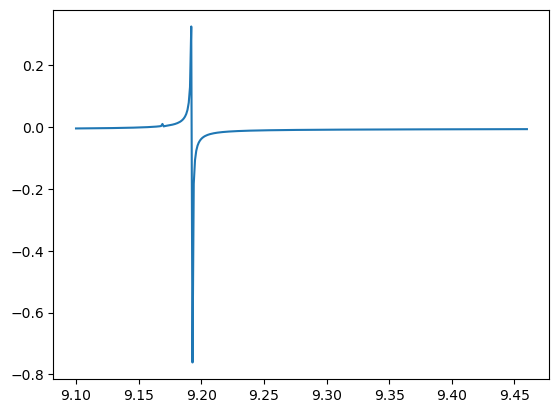

In [125]:
plt.plot(fdata, ydata.imag)
plt.show()

In [126]:
y0s.shape

(1, 361)

## Plot the admittance functions

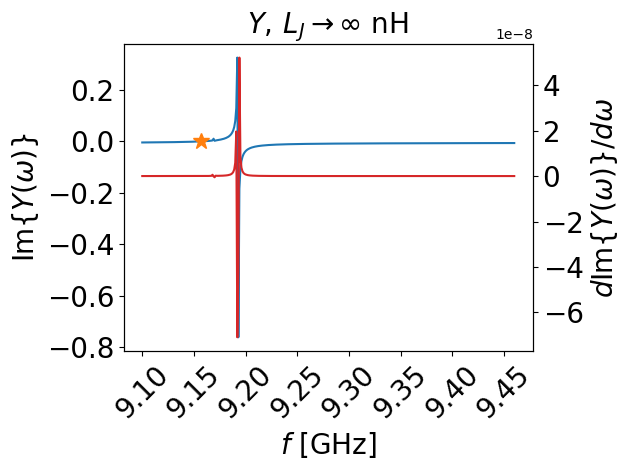

In [127]:
dstr = datetime.datetime.today().strftime('%y%m%d')
lsize = 14
fsize = 20
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
yim = y0s[0].imag
zero_xing_idxs = np.where(np.diff(np.sign(yim))>0)[0]

fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.plot(fdata, y0s[0].imag,
        '-', color='tab:blue')

wpj, yre_int, yim_int, ypp_zero_xings = get_zero_crossings(fdata * 1e9, y0s[0], fscale=1e9)

ax.plot(wpj/(2*np.pi*1e9), yim_int(wpj/(2*np.pi)), ms=12, marker='*', ls='', color='tab:orange')
ax2 = ax.twinx()
ax2.plot(fdata, np.gradient(y0s[0], 2*np.pi*(fdata[1]-fdata[0])).imag/1e9,
        '-', color='tab:red')
ax.set_title(label=r'$Y,\,L_J \to \infty$ nH', fontsize=fsize)
ax.set_xlabel(r'$f$ [GHz]', fontsize=fsize)
ax.set_ylabel(r'$\mathrm{Im}\{Y(\omega)\}$', fontsize=fsize)
ax2.set_ylabel(r'$d\mathrm{Im}\{Y(\omega)\}/d\omega$', fontsize=fsize)
set_xaxis_rot(ax, 45)
#ax.set_ylim([-0.5, 0.5])
#ax2.set_ylim([-0.5e-9, 0.5e-9])
set_axes_fonts(ax, fsize)
set_axes_fonts(ax2, fsize)
plt.show()

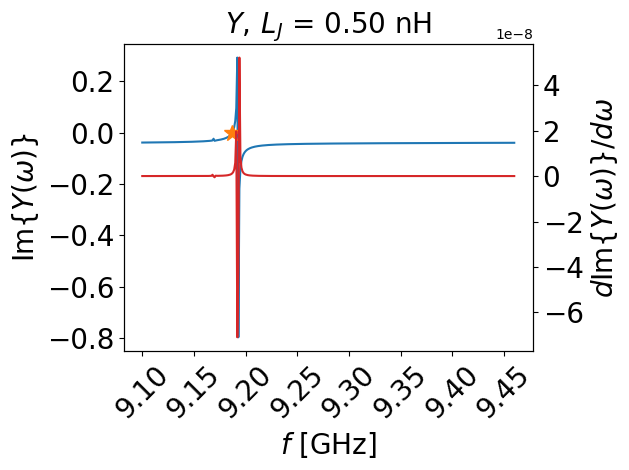

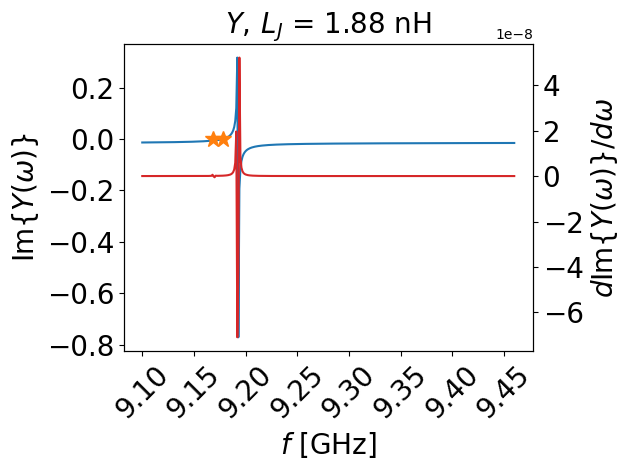

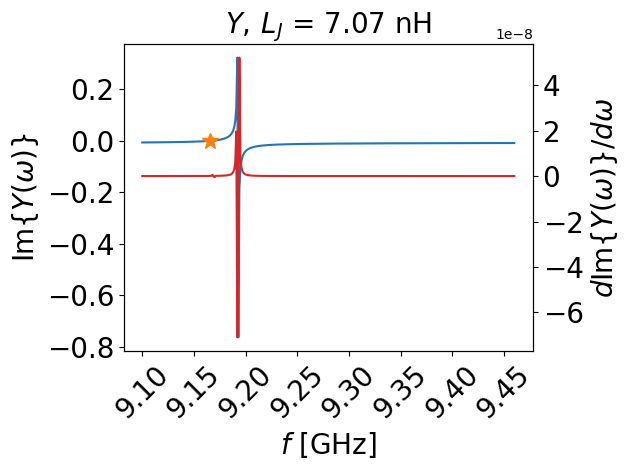

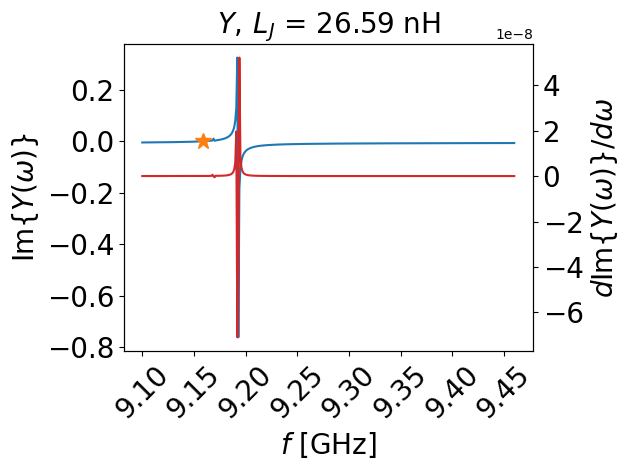

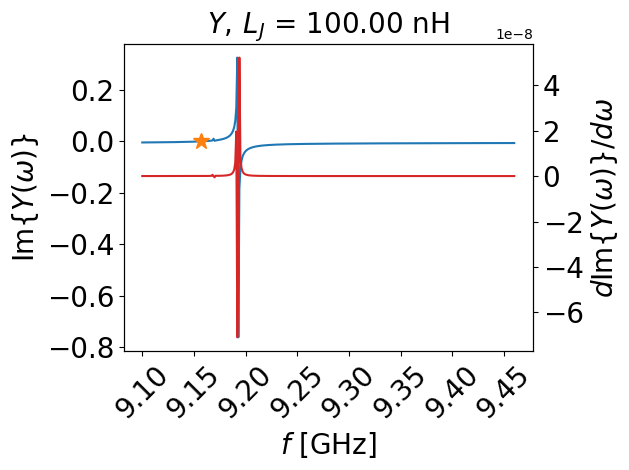

In [128]:
for idx, ysj in enumerate(ys):
    fig, ax = plt.subplots(1, 1, tight_layout=True)
    ax.plot(fdata, ysj.imag,
            '-', color='tab:blue')
    ax2 = ax.twinx()
    ax2.plot(fdata, np.gradient(ysj, 2*np.pi*(fdata[1]-fdata[0])).imag/1e9,
            '-', color='tab:red')
    wpj, yre_int, yim_int, ypp_zero_xings = get_zero_crossings(fdata * 1e9, ysj, fscale=1e9)
    
    # ax.plot(fdata[zero_xing_idxs], yim[zero_xing_idxs], ms=12, marker='*', ls='', color='tab:orange')
    ax.plot(wpj/(2*np.pi*1e9), yim_int(wpj/(2*np.pi)), ms=12, marker='*', ls='', color='tab:orange')
    ax.set_title(label=r'$Y,\,L_J$ = %.2f nH' % (LJs[idx] / 1e-9), fontsize=fsize)
    ax.set_xlabel(r'$f$ [GHz]', fontsize=fsize)
    ax.set_ylabel(r'$\mathrm{Im}\{Y(\omega)\}$', fontsize=fsize)
    ax2.set_ylabel(r'$d\mathrm{Im}\{Y(\omega)\}/d\omega$', fontsize=fsize)
    set_xaxis_rot(ax, 45)
 #   ax.set_ylim([-0.5, 0.5])
  #  ax2.set_ylim([-0.5e-9, 0.5e-9])
    set_axes_fonts(ax, fsize)
    set_axes_fonts(ax2, fsize)
    #leg = set_leg_outside(ax, lsize)
    #leg = set_leg_outside(ax2, lsize)
    # ax.set_xscale('log')
plt.show()

In [129]:
ys.shape

(5, 361)

In [130]:
LJs.shape

(5,)

In [131]:
get_zero_crossings(fdata, ydata, fscale=1)

(array([57.53168309]),
 array([0.02953925]))

In [132]:
dstr = datetime.datetime.today().strftime('%y%m%d')
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
fig, ax = plt.subplots(1, 1, tight_layout=True)
yvals = []
for idx, LJ in enumerate(LJs):
    y = ys[idx]
    wpj, yre_int, yim_int, ypp_zero_xings = get_zero_crossings(fdata * 1e9, y, fscale=1e9)
    yim = y.imag
    yvals.append(yim_int(wpj/(2*np.pi)))
yvals = np.asarray(yvals).T
ax.set_ylabel(r'$\mathrm{Im}\{Y(\omega_p)\}$')
ax.set_xlabel(r'$L_J$ [nH]')
#ax.set_ylim(-5e-15, 5e-15)
for yidx, yv in enumerate(yvals):
    ax.semilogx(LJs/1e-9, yv, 'o-', label=r'Mode-%d' % (yidx + 1))
    # ax.plot(LJs/1e-9, yv, 'o-', label=r'Mode-%d' % (yidx + 1))
set_leg_outside(ax, 10)
plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

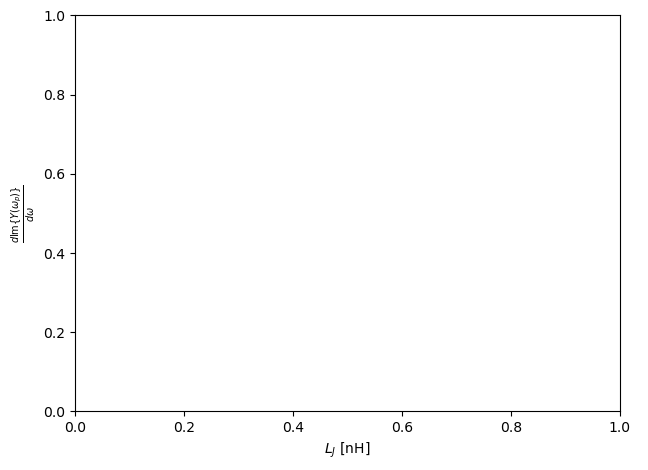

In [20]:
dstr = datetime.datetime.today().strftime('%y%m%d')
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
fig, ax = plt.subplots(1, 1, tight_layout=True)
dys = []
for idx, LJ in enumerate(LJs):
    y = ys[idx]
    yim = y.imag
    wpj, yre_int, yim_int, ypp_zero_xings = get_zero_crossings(fdata * 1e9, y, fscale=1e9)
    # ygrad = np.gradient(y, fdata[1]-fdata[0]) / 1e9
    # idxs = np.where(np.diff(np.sign(yim))>0)[0]
    # dys.append(ygrad[idxs].imag)
    dys.append(ypp_zero_xings)
dys = np.asarray(dys).T
ax.set_ylabel(r'$\frac{d\mathrm{Im}\{Y(\omega_p)\}}{d\omega}$')
ax.set_xlabel(r'$L_J$ [nH]')
for yidx, yv in enumerate(dys):
    ax.semilogx(LJs/1e-9, yv, 'o-', label=r'Mode-%d' % (yidx + 1))
    # ax.plot(LJs/1e-9, yv, 'o-', label=r'Mode-%d' % (yidx + 1))
set_leg_outside(ax, 10)
plt.show()

## Slider of all admittances

In [ ]:
%matplotlib notebook
%matplotlib inline
from importlib import reload
import matplotlib.pyplot as plt
reload(plt)
from matplotlib.widgets import Button, Slider

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.25)
yim = y0s[0].imag

wpj0, yre_int, y0im_int, ypp_zero_xings = get_zero_crossings(fdata * 1e9, y0s[0], fscale=1e9)

l, = ax.plot(fdata, y0s[0].imag, lw=2, color='tab:blue', marker='o', ms=3)
m, = ax.plot(wpj0/(2*np.pi*1e9), y0im_int(wpj0/(2*np.pi)),
             marker='*', color='tab:orange', ls='', ms=12)
ax.axhline(y=0, color='k', ls='--', alpha=0.5)
ax.set_ylim(-0.1, 0.1)
ax.set_ylabel(r'$\mathrm{Im}\{Y(\omega)\}$')
ax.set_xlabel('f [GHz]')

ax_bot = fig.add_axes([0.25, 0.1, 0.65, 0.03])

# create the sliders
samp = Slider(
    ax_bot, r'$L_J$ [index]', 0, LJs.size,
    valinit=20, valstep=list(range(LJs.size+1)),
    color="blue"
)

def update(val):
    idx = samp.val
    if np.isclose(idx, 0):
        l.set_ydata(y0s[0].imag)
        m.set_xdata(wpj0/(2*np.pi*1e9))
        m.set_ydata(y0im_int(wpj0/(2*np.pi)))
    else:
        ax.set_title(r'$L_J = %.2f$ nH' % (LJs[idx] / 1e-9))
        y = ys[idx-1]
        wpj, yre_int, yim_int, ypp_zero_xings = get_zero_crossings(fdata * 1e9, y, fscale=1e9)
        l.set_ydata(y.imag)
        m.set_xdata(wpj/(2*np.pi*1e9))
        m.set_ydata(yim_int(wpj/(2*np.pi)))
    fig.canvas.draw_idle()

samp.on_changed(update)

ax_reset = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(ax_reset, 'Reset', hovercolor='0.975')

def reset(event):
    samp.reset()
    ax.set_title(r'$L_J\to\infty$ nH')
    l.set_ydata(y0s[0].imag)
    m.set_xdata(wpj0/(2*np.pi*1e9))
    m.set_ydata(y0im_int(wpj0/(2*np.pi)))
button.on_clicked(reset)

plt.show()

## Slider of real admittances

In [ ]:
from matplotlib.widgets import Button, Slider
%matplotlib notebook
%matplotlib inline

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.25)
yim = y0s[0].imag

wpj0, y0re_int, y0im_int, ypp_zero_xings = get_zero_crossings(fdata * 1e9, y0s[0], fscale=1e9)

l, = ax.plot(fdata, y0s[0].real, lw=2, color='tab:blue', marker='o', ms=3)
m, = ax.plot(wpj0/(2*np.pi*1e9), y0re_int(wpj0/(2*np.pi)),
             marker='*', color='tab:orange', ls='', ms=12)
#ax.set_ylim(-0.5e-9, 0.5e-8)
ax.set_ylabel(r'$\mathrm{Re}\{Y(\omega)\}$')
ax.set_xlabel('f [GHz]')

ax_bot = fig.add_axes([0.25, 0.1, 0.65, 0.03])

# create the sliders
samp = Slider(
    ax_bot, r'$L_J$ [index]', 0, LJs.size,
    valinit=20, valstep=list(range(LJs.size+1)),
    color="blue"
)

def update(val):
    idx = samp.val
    if np.isclose(idx, 0):
        l.set_ydata(y0s[0].real)
        m.set_xdata(wpj0/(2*np.pi*1e9))
        m.set_ydata(y0re_int(wpj0/(2*np.pi)))
    else:
        ax.set_title(r'$L_J = %.2f$ nH' % (LJs[idx] / 1e-9))
        y = ys[idx-1]
        wpj, yre_int, yim_int, ypp_zero_xings = get_zero_crossings(fdata * 1e9, y, fscale=1e9)
        l.set_ydata(y.real)
        m.set_xdata(wpj/(2*np.pi*1e9))
        m.set_ydata(yre_int(wpj/(2*np.pi)))
    fig.canvas.draw_idle()

samp.on_changed(update)

ax_reset = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(ax_reset, 'Reset', hovercolor='0.975')

def reset(event):
    samp.reset()
    ax.set_title(r'$L_J\to\infty$ nH')
    l.set_ydata(y0s[0].real)
    m.set_xdata(wpj0/(2*np.pi*1e9))
    m.set_ydata(y0re_int(wpj0/(2*np.pi)))
button.on_clicked(reset)

plt.show()

## Plot the modes of coupled structure

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
dstr = datetime.datetime.today().strftime('%y%m%d')
lsize = 14
fscale = 1e9
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, wppp in enumerate(wps1):
    ax.plot(LJs/1e-9, wppp/(2*np.pi*fscale),
            'o', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
    #ax.plot(LJs/1e-9, [wps0[idx]/(2*np.pi*fscale)]*len(LJs),
    #        '--', color=cycle[idx%clen])
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'Eigenfrequencies [GHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
#ax.plot(LJs/1e-9, fJ/fscale, '--', label='Coupler\nMode\n'+r'$(L_JC_J)^{-1/2}$',
#       color=cycle[(idx+1)%clen])
#ax.set_ylim([0, 20.])
set_axes_fonts(ax, fsize)
leg = set_leg_outside(ax, lsize)
ax.set_xscale('log')
fig.savefig(f'../figs/modes_term_bbq_inductive_planar_sapphire_{dstr}.pdf',
             bbox_extra_artists=(leg, ), bbox_inches='tight',
            transparent=True, format='pdf')

## Plot the splittings of the lowest modes vs LJ

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
fscale2 = 1e6
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
ax.plot(LJs/1e-9, (wps1[1]-wps1[0])/(2*np.pi*fscale2),
           'o-',
            color=cycle[0%clen])
# ax.plot(LJs/1e-9, np.ones(LJs.size) * dw/(fscale2), 'k--')
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'Mode Splitting (1,2) [MHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
#ax.set_ylim([0, 150])
#ax.set_xlim([0.5, 2.2])
ax.set_xscale('log')
fig.savefig(f'../figs/modes_splitting_term_bbq_inductive_planar_sapphire_{dstr}.pdf',
            format='pdf')

## Mode losses

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, Q in enumerate(Qps1):
    ax.plot(LJs/1e-9, 1./Q,
            'o-', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
ax.plot(LJs/1e-9, 2e-8 * np.ones(len(LJs)),
        'k--', label=r'$\tan\delta$')
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$Q_p^{-1}$', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
set_leg_outside(ax, lsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/mode_losses_no_filter.pdf', bbox_extra_artists=(leg, ), bbox_inches='tight',
            transparent=True, format='pdf')

In [ ]:
np.max(1./Qps1[0]) / np.min(1./Qps1[0])

## Mode $T_1$'s

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
fscale2 = 1e6
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, Q in enumerate(Qps1):
    ax.plot(LJs/1e-9, 1e6 * Q / wps1[idx],
            'o-', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
ax.plot(LJs/1e-9, 100*np.ones(LJs.size), 'k:',
        lw=2, label=r'100 $\mu$s $T_1$')
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$T_1$ [$\mu$s]', fontsize=fsize)
# ax.plot(LJs/1e-9, np.ones(LJs.size) * dw/(fscale2), 'k--')
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
set_leg_outside(ax, lsize)
#ax.set_ylim([1e-2, 350])
#ax.set_xlim([0.5, 2.2])
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/T1_modes_coupled_{dstr}.pdf',
            format='pdf')

## Black box results

### $\alpha_p$ and $\chi_{pq}$

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
Nmodes = 4
fscale3 = 1e3
for idx in range(Nmodes):
    ax.plot(LJs/1e-9, 0.5 * np.abs(chis1[idx, idx, :]) / fscale3,
            'o-', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$|\alpha_p|$ [kHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
set_leg_outside(ax, lsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/mode_alpha_term_bbq_inductive_planar_sapphire_{dstr}.pdf', format='pdf')

In [ ]:
# Chi, lower triangle
chiT = np.array([np.triu(chis1[:,:,i]) for i in range(len(LJs))]).T
gT = np.array([np.triu(gDs1[:,:,i]) for i in range(len(LJs))]).T
NM = 2
chiT[0:NM,0:NM,0]

fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
NM = 2
idx = 0
for i in range(NM):
    for j in range(NM):
        if (i != j) and np.any(chiT[i, j, :] != 0.):
            ax.plot(LJs/1e-9, np.abs(chiT[i, j, :]) / fscale3,
                'o-', label=r'$\chi_{%d,%d}$' % (i + 1, j + 1),
                color=cycle[idx%clen])
            idx += 1
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$|\chi_{pq}|$ [kHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
set_leg_outside(ax, lsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/mode_chi_term_bbq_inductive_planar_sapphire_{dstr}.pdf', format='pdf')

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
NM = 2
idx = 0
for i in range(NM):
    for j in range(NM):
        if (i != j) and np.any(gT[i, j, :] != 0.):
            ax.plot(LJs/1e-9, np.abs(gT[i, j, :]) / fscale3,
                'o-', label=r'$g_{%d,%d}$' % (i + 1, j + 1),
                color=cycle[idx%clen])
            idx += 1
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$|g_{pq}|$ [kHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
set_leg_outside(ax, lsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/mode_g_term_bbq_inductive_planar_sapphire_{dstr}.pdf', format='pdf')

## Plot the circuit parameters

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
Nmodes = 4
fscale3 = 1e3
# Lps1, Cps1, Qps1,
for idx in range(Nmodes):
    ax.plot(LJs/1e-9, Lps1[idx] / 1e-9,
            'o-', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$L_p$ [nH]', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
set_leg_outside(ax, lsize)
ax.set_xscale('log')
ax.set_yscale('log')

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
Nmodes = 4
fscale3 = 1e3
# Lps1, Cps1, Qps1,
for idx in range(Nmodes):
    ax.plot(LJs/1e-9, Cps1[idx] / 1e-15,
            'o-', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$C_p$ [fF]', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
set_leg_outside(ax, lsize)
ax.set_xscale('log')
ax.set_yscale('log')

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
Nmodes = 4
fscale3 = 1e3
# Lps1, Cps1, Qps1,
for idx in range(Nmodes):
    ax.plot(LJs/1e-9, Rps1[idx],
            'o-', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$R_p$ [$\Omega$]', fontsize=fsize)
set_xaxis_rot(ax, 45)
#ax.set_ylim(1e8, 5e10)
set_axes_fonts(ax, fsize)
set_leg_outside(ax, lsize)
ax.set_xscale('log')
ax.set_yscale('log')

In [ ]:
wsize = 19
order = 1
wrange = 175
yresmooth = savitzky_golay_smoothing(ys[-1][0:wrange].real+2e-11, wsize, order)
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
Nmodes = 4
ax.plot(fdata, (ys[-1].real+2e-11)/1e-10, color='tab:blue', marker='o', ls='', 
        label='Shifted\nRaw Data')
ax.plot(fdata[0:wrange], yresmooth/1e-10, color='tab:red',
        label='Savitzky-Golay\nSmoothed')
#ax.set_ylim(-0.5, 3.0)
#ax.set_xlim(0, 5.4)
set_axes_fonts(ax, fsize)
ax.set_ylabel(r'$\mathrm{Re}\{Y(\omega)\}\times 10^{-10}\,\mathrm{S}$',
              fontsize=fsize)
ax.set_xlabel('Frequency [GHz]', fontsize=fsize)
leg = set_leg_outside(ax, lsize)
fig.savefig(f'../figs/savitzky_golay_smoothed_zoom_ReY.pdf',
             bbox_extra_artists=(leg, ), bbox_inches='tight',
            transparent=True, format='pdf')

In [ ]:
wsize = 19
order = 1
wrange = 175
yresmooth = savitzky_golay_smoothing(ys[-1][0:wrange].real+2e-11, wsize, order)
fig, ax = plt.subplots(1, 1, figsize=(8,6), tight_layout=True)
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
Nmodes = 4
ax.plot(fdata, ys[-1].real/1e-2, color='tab:gray', marker='o', ls='', 
        label='Raw Data', alpha=0.5)
ax.plot(fdata, (ys[-1].real+2e-11)/1e-2, color='tab:blue', marker='d', ls='', 
        label='Shifted\nRaw Data')
ax.plot(fdata[0:wrange], yresmooth/1e-2, color='tab:red',
        label='Savitzky-Golay\nSmoothed')
# Plot the zeros
wpj, yre_int, yim_int, ypp_zero_xings = get_zero_crossings(fdata * 1e9, ys[-1], fscale=1e9)
ax.plot(wpj/(2*np.pi*1e9), yre_int(wpj/(2*np.pi))/1e-2, ls='',
       ms=10, marker='*', color='tab:orange',
       label='Resonances')
set_xaxis_rot(ax, 45)
#ax.set_ylim(-0.5, 3.0)
ax.set_ylim(-0.5, 3)
set_axes_fonts(ax, fsize)
ax.set_ylabel(r'$\mathrm{Re}\{Y(\omega)\}\,[10^{-2}\,\mathrm{S}]$',
              fontsize=fsize)
ax.set_xlabel('Frequency [GHz]', fontsize=fsize)
leg = set_leg_outside(ax, lsize)
fig.savefig(f'../figs/savitzky_golay_smoothed_ReY.pdf',
             bbox_extra_artists=(leg, ), bbox_inches='tight',
            transparent=True, format='pdf')

In [ ]:
wsize = 19
order = 1
wrange = 175
yresmooth = savitzky_golay_smoothing(ys[-1][0:wrange].real+2e-11, wsize, order)
fig, ax = plt.subplots(1, 1, figsize=(8, 6), tight_layout=True)
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
Nmodes = 4
ax.plot(fdata, ys[-1].imag, color='tab:gray', marker='o', ls='', 
        label='Raw Data', alpha=0.5)
ax.axhline(y=0, color='k', ls='--')
# Plot the zeros
wpj, yre_int, yim_int, ypp_zero_xings = get_zero_crossings(fdata * 1e9, ys[-1], fscale=1e9)
ax.plot(wpj/(2*np.pi*1e9), yim_int(wpj/(2*np.pi)), ls='',
       ms=10, marker='*', color='tab:orange',
       label='Resonances')

ax.set_ylim(-0.05, 0.05)
# ax.set_xlim(0, 5.4)
set_axes_fonts(ax, fsize)
set_xaxis_rot(ax, 45)
ax.set_ylabel(r'$\mathrm{Im}\{Y(\omega)\}\,[\mathrm{S}]$',
              fontsize=fsize)
ax.set_xlabel('Frequency [GHz]', fontsize=fsize)
leg = set_leg_outside(ax, lsize)
fig.savefig(f'../figs/yim_comparison.pdf',
             bbox_extra_artists=(leg, ), bbox_inches='tight',
            transparent=True, format='pdf')

## Eigenmode Analysis

### Load the data from file

In [ ]:
wdata = np.genfromtxt('../data/two_post_coupler_modes_231030.csv', names=True, delimiter=',')
wdata = np.genfromtxt('../data/two_post_coupler_modes_231121.csv', names=True, delimiter=',')
wdata = np.genfromtxt('../data/two_post_coupler_modes_vacuum_231121.csv', names=True, delimiter=',')

# Data for the open and short circuit cases
wshort = np.asarray([7.06010, 8.00722, 9.07815, 9.07985])
wopen = np.asarray([6.92575, 7.05794, 9.07463, 9.07722])

print(f'{wdata.dtype}')
LJs = wdata['LJ_nH']
Nmodes = 4
modes = np.array([wdata[f'reMode{mode:d}_'] for mode in range(1, Nmodes+1)])

### Fit the mode that tunes to a simple circuit model

In [ ]:
from scipy.optimize import curve_fit
import uncertainties
def fitmodes(LJ, L, C, w0):
    return 1. / np.sqrt((L + LJ) * C) + w0

popt, pcov = curve_fit(fitmodes, LJs * 1e-9, 2*np.pi*modes_to_fit, p0=(1e-9, 150e-15, 2*np.pi*7e9))
errors = np.sqrt(np.diag(pcov))
mode_fit = fitmodes(LJs*1e-9, *popt) / (2*np.pi)
upper = fitmodes(LJs*1e-9, *(popt + 2 * errors)) / (2 * np.pi)
lower = fitmodes(LJs*1e-9, *(popt - 2 * errors)) / (2 * np.pi)

In [ ]:
L, C, w0 = popt
1./np.sqrt(L * C * (2*np.pi)**2) / 1e9, w0 / (2 * np.pi * 1e9), L / 1e-9, C / 1e-12

In [ ]:
def format_error_string(param_str, val, val_err, units=None):
    """
    Formats the value, error and label with uncertainties
    """
    round_sigfig = lambda x, n : round(x, n -
    int(np.floor(np.log10(abs(x)))) - 1)

    # Handle inf case
    if np.isclose(val_err, np.inf) or np.isclose(val_err, 0, atol=1e-16):
        val_err = np.inf
        out_str = r'$%s: %.2g\pm %g$' % (param_str, val, val_err)
    else:
        val_err = round_sigfig(val_err, 1)

    ## Uncertainty objects
    val_un = uncertainties.ufloat(val, val_err)

    # Build a string with the results
    latex_str = f'{val_un:L}'
    out_str = r'$%s: %s$' % (param_str, latex_str)
    
    if units is not None:
        out_str += ' %s' % units
    
    return out_str

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(8, 6))
dstr = datetime.datetime.today().strftime('%y%m%d')
lsize = 14
fscale = 1e9
fsize = 20
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
mode_names = ['Mode-1 (Comm)', 'Mode-2 (Diff)', 'Mode-3', 'Mode-4']
for idx, wppp in enumerate(modes):
    ax.plot(LJs, wppp/(fscale),
            'o', label=mode_names[idx],
            color=cycle[idx%clen])
    ax.plot([1e-2], wshort[idx], '*',
           color=cycle[idx%clen])
    ax.plot([1e3], wopen[idx], 'x',
           color=cycle[idx%clen])
    #ax.plot(LJs/1e-9, [wps0[idx]/(2*np.pi*fscale)]*len(LJs),
    #        '--', color=cycle[idx%clen])

# Best fit label
wscale = 2*np.pi*1e9
Lscale = 1e-9
Cscale = 1e-12
L_label = format_error_string(r'L', popt[0]/Lscale, errors[0]/Lscale, units='nH')
C_label = format_error_string(r'C', popt[1]/Cscale, errors[1]/Cscale, units='pF')
w0_label = format_error_string(r'\omega_0\,/\,2\pi',
                               popt[2]/wscale, errors[2]/wscale, units='GHz')
prelabel = r'$\omega_0 + \frac{1}{\sqrt{(L+L_J)C}}$'
label =  '\n'.join([prelabel, L_label, C_label, w0_label])
ax.plot(LJs, mode_fit/1e9, '-', color=cycle[1], label=label)
ax.fill_between(LJs, lower/1e9, y2=upper/1e9, color=cycle[1], alpha=0.25)
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'Eigenfrequencies [GHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
#ax.plot(LJs/1e-9, fJ/fscale, '--', label='Coupler\nMode\n'+r'$(L_JC_J)^{-1/2}$',
#       color=cycle[(idx+1)%clen])
ax.set_ylim([6., 9.52])
set_axes_fonts(ax, fsize)
# leg = ax.legend(loc=(0.05, 0.08), fontsize=12)
# leg = ax.legend(loc='best', fontsize=12)
leg = set_leg_outside(ax, 12)
ax.set_xscale('log')
#plt.grid(True, which='both')
fig.savefig(f'../figs/modes_eigenmode_two_post_coupler_{dstr}.svg',
             bbox_extra_artists=(leg, ), bbox_inches='tight',
            transparent=True, format='svg')

## Fully Coupled Structure Modes vs. $L_J$

In [ ]:
wdata = np.genfromtxt('../data/modes_vs_LJ_fully_coupled_structure_lambda2_240326.csv', names=True, delimiter=',')
# wdata = np.genfromtxt('../data/modes_vs_LJ_fully_coupled_structure_240319.csv', names=True, delimiter=',')
Nmodes = 6
modes = np.array([wdata[f'reMode{mode:d}_'] for mode in range(1, Nmodes+1)])
LJs = wdata['LJ_nH']

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(8, 6))
dstr = datetime.datetime.today().strftime('%y%m%d')
lsize = 14
fscale = 1e9
fsize = 20
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
mode_names = ['Mode-1 (left cav)', 'Mode-2 (right cav)',
              'Mode-3 (Comm)', 'Mode-4 (Diff)',
              'Mode-5 (center cylinder)', 'Mode-6 (center cylinder)']
err = 0.02 * 1e-2
for idx, wppp in enumerate(modes):
    ax.errorbar(LJs, wppp/(fscale),
                yerr=err * wppp/(fscale),
            marker='o', label=mode_names[idx],
            color=cycle[idx%clen],
               capsize=5)
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'Eigenfrequencies [GHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
# ax.set_ylim([4.8, 4.9])
set_axes_fonts(ax, fsize)
leg = set_leg_outside(ax, 12)
ax.set_xscale('log')
#plt.grid(True, which='both')
fig.savefig(f'../figs/modes_eigenmode_two_post_coupler_full_structure_m21_{dstr}.svg',
             bbox_extra_artists=(leg, ), bbox_inches='tight',
            transparent=True, format='svg')

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(8, 6))
dstr = datetime.datetime.today().strftime('%y%m%d')
lsize = 14
fscale = 1e9
cscale = 1e6
fsize = 20
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
err = 0.05 * 1e-2
mode_names = ['Mode-1 (left cav)', 'Mode-2 (right cav)',
              'Mode-3 (Comm)', 'Mode-4 (Diff)',
              'Mode-5 (center cylinder)', 'Mode-6 (center cylinder)']
ax.errorbar(LJs, (modes[1]-modes[0])/(cscale),
            yerr=err*np.sqrt(modes[1]**2 + modes[2]**2)/(cscale),
            marker='o',capsize=5)
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'Mode splitting (2-1) [MHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
# ax.set_ylim([4.8, 4.9])
set_axes_fonts(ax, fsize)
leg = set_leg_outside(ax, 12)
ax.set_xscale('log')
#plt.grid(True, which='both')
fig.savefig(f'../figs/modes_eigenmode_two_post_coupler_full_structure_m21_{dstr}.svg',
             bbox_extra_artists=(leg, ), bbox_inches='tight',
            transparent=True, format='svg')

## Fully coupled structure modes vs. cavity offset

In [ ]:
wdata = np.genfromtxt('../data/modes_vs_cavity_offset_lambda2_structure_240326.csv', names=True, delimiter=',')
# wdata = np.genfromtxt('../data/modes_vs_LJ_fully_coupled_structure_240319.csv', names=True, delimiter=',')
Nmodes = 6
modes = np.array([wdata[f'reMode{mode:d}_'] for mode in range(1, Nmodes+1)])
x = wdata['ab_offset_mm']

## Micromachined cavity, orientation 1

In [ ]:
# wdata = np.genfromtxt('../data/mu_machined_b_actual_dimensions_modes_vs_ytunnel_240417.csv', names=True, delimiter=',')
wdata = np.genfromtxt('../data/mu_machined_b_actual_dimensions_modes_vs_LJ_240430.csv', names=True, delimiter=',')
wdata = np.genfromtxt('../data/mu_machined_a_actual_dimensions_modes_vs_LJ_240521.csv', names=True, delimiter=',')
# wdata = np.genfromtxt('../data/mu_machined_b_actual_dimensions_modes_vs_hcav_240501.csv', names=True, delimiter=',')
# wdata = np.genfromtxt('../data/modes_vs_LJ_fully_coupled_structure_240319.csv', names=True, delimiter=',')
# wdata = np.genfromtxt('../data/mu_machined_b_actual_dimensions_modes_vs_hcav_LJ_240514.csv', names=True, delimiter=',')
Nmodes = 8
modes = np.array([wdata[f'reMode{mode:d}_'] for mode in range(1, Nmodes+1)])
# x = wdata['ytunnel_mm']
x = wdata['LJ_nH']
# x = np.unique(wdata['hcav_mm'])
# y = np.unique(wdata['LJ_nH'])

In [ ]:
x

In [ ]:
modes

In [ ]:
modes3d = modes.reshape([Nmodes, y.size, x.size])

In [ ]:
for i in range(Nmodes):
    fname = f'mode_{i}_vs_hcav_LJ.pdf'
    plot_2d_cmap(x,
        y,
        modes3d[i, :, :] / 1e9,
        fname,
        xstr=r'$h_{\mathrm{cav}}$ [mm]',
        ystr=r'$L_J$ [nH]',
        tstr='',
        cbar_str=f'Mode-{i+1}\n[GHz]')


In [ ]:
for i in range(Nmodes - 1):
    fname = f'delta_{i+2}{i+1}_vs_hcav_LJ.pdf'
    plot_2d_cmap(x,
        y,
        (modes3d[i+1, :, :] - modes3d[i, :, :]) / 1e6,
        fname,
        xstr=r'$h_{\mathrm{cav}}$ [mm]',
        ystr=r'$L_J$ [nH]',
        tstr='',
        cbar_str=r'$\Delta_{%d%d}$' % (i+2, i+1) + '\n[MHz]',
        norm_type='linear',
        zref=(np.min(modes3d[i+1,:,:]-modes3d[i,:,:]),
                np.min(modes3d[i+1,:,:]-modes3d[i,:,:])))

In [ ]:
x.shape

In [ ]:
y.shape

In [ ]:
wdata = np.genfromtxt('../data/mu_machined_b_actual_dimensions_modes_vs_LJ_240417.csv', names=True, delimiter=',')
# wdata = np.genfromtxt('../data/modes_vs_LJ_fully_coupled_structure_240319.csv', names=True, delimiter=',')
Nmodes = 8
modes = np.array([wdata[f'reMode{mode:d}_'] for mode in range(1, Nmodes+1)])
x = wdata['LJ_nH']

In [ ]:
x

In [ ]:
modes

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(8, 6))
dstr = datetime.datetime.today().strftime('%y%m%d')
lsize = 14
fscale = 1e9
fsize = 20
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
#mode_names = ['Mode-1 (left cav)', 'Mode-2 (right cav)',
#              'Mode-3 (Comm)', 'Mode-4 (Diff)',
#              'Mode-5 (center cylinder)', 'Mode-6 (center cylinder)']
err = 0.05 * 1e-2
for idx, wppp in enumerate(modes):
    ax.errorbar(x, wppp/(fscale),
                yerr=err * wppp/(fscale),
            marker='o', label=f'Mode-{idx+1}',#mode_names[idx],
            color=cycle[idx%clen],
               capsize=5)

ax.set_xlabel(r'$h_{\mathrm{cavity}}$ [mm]', fontsize=fsize)
# ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
# ax.set_xlabel(r'$y_{\mathrm{tunnel}}$ [mm]', fontsize=fsize)
ax.set_ylabel(r'Eigenfrequencies [GHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
# ax.set_xscale('log')
# ax.set_yscale('log')
#ax.set_ylim([9.2, 9.25])
set_axes_fonts(ax, fsize)
leg = set_leg_outside(ax, 12)
#plt.grid(True, which='both')
fig.savefig(f'../figs/modes_eigenmode_micromachined_{dstr}.svg',
            bbox_extra_artists=(leg, ), bbox_inches='tight',
            transparent=True, format='svg')

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(8, 6))
dstr = datetime.datetime.today().strftime('%y%m%d')
lsize = 14
fscale = 1e9
fsize = 20
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
#mode_names = ['Mode-1 (left cav)', 'Mode-2 (right cav)',
#              'Mode-3 (Comm)', 'Mode-4 (Diff)',
#              'Mode-5 (center cylinder)', 'Mode-6 (center cylinder)']
err = 0.005 * 1e-2
for idx, wppp in enumerate(modes):
    ax.errorbar(x, wppp/(fscale),
                yerr=err * wppp/(fscale),
            marker='o', label=f'Mode-{idx+1}', #mode_names[idx],
            color=cycle[idx%clen],
               capsize=5)
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'Eigenfrequencies [GHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
ax.set_ylim([9.325, 9.36])
set_axes_fonts(ax, fsize)
leg = set_leg_outside(ax, 12)
#plt.grid(True, which='both')
fig.savefig(f'../figs/modes_eigenmode_two_post_coupler_full_structure_m21_{dstr}.svg',
             bbox_extra_artists=(leg, ), bbox_inches='tight',
            transparent=True, format='svg')

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(8, 6))
dstr = datetime.datetime.today().strftime('%y%m%d')
lsize = 14
fscale = 1e9
cscale = 1e6
fsize = 20
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
err = 0.005 * 1e-2
mode_names = ['Mode-1 (left cav)', 'Mode-2 (right cav)',
              'Mode-3 (Comm)', 'Mode-4 (Diff)',
              'Mode-5 (center cylinder)', 'Mode-6 (center cylinder)']
ax.errorbar(x, (modes[1]-modes[0])/(cscale),
            yerr=err*np.sqrt(modes[1]**2 + modes[2]**2)/(cscale),
            marker='o',capsize=5)
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'Mode splitting (2-1) [MHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
# ax.set_ylim([4.8, 4.9])
set_axes_fonts(ax, fsize)
leg = set_leg_outside(ax, 12)
#plt.grid(True, which='both')
fig.savefig(f'../figs/modes_eigenmode_two_post_coupler_full_structure_m21_{dstr}.svg',
             bbox_extra_artists=(leg, ), bbox_inches='tight',
            transparent=True, format='svg')

In [ ]:
# Best fit label
wscale = 2*np.pi*1e9
Lscale = 1e-9
Cscale = 1e-12
L_label = format_error_string(r'L', popt[0]/Lscale, errors[0]/Lscale, units='nH')
C_label = format_error_string(r'C', popt[1]/Cscale, errors[1]/Cscale, units='pF')
w0_label = format_error_string(r'\omega_0\,/\,2\pi',
                               popt[2]/wscale, errors[2]/wscale, units='GHz')
prelabel = r'$\omega_0 + \frac{1}{\sqrt{(L+L_J)C}}$'
label =  '\n'.join([prelabel, L_label, C_label, w0_label])
ax.plot(LJs, mode_fit/1e9, '-', color=cycle[1], label=label)
ax.fill_between(LJs, lower/1e9, y2=upper/1e9, color=cycle[1], alpha=0.25)
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'Eigenfrequencies [GHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
#ax.plot(LJs/1e-9, fJ/fscale, '--', label='Coupler\nMode\n'+r'$(L_JC_J)^{-1/2}$',
#       color=cycle[(idx+1)%clen])
ax.set_ylim([6., 9.52])
set_axes_fonts(ax, fsize)
# leg = ax.legend(loc=(0.05, 0.08), fontsize=12)
# leg = ax.legend(loc='best', fontsize=12)
leg = set_leg_outside(ax, 12)
ax.set_xscale('log')
#plt.grid(True, which='both')
fig.savefig(f'../figs/modes_eigenmode_two_post_coupler_{dstr}.svg',
             bbox_extra_artists=(leg, ), bbox_inches='tight',
            transparent=True, format='svg')

## Fit Jens's circuit model

In [ ]:
!pip install uncertainties

In [ ]:
"""

Circuit model with inductance to ground and parallel, residual inductance
with the LJ, i.e. parasitic inductive coupling at LJ->infinity,0

         2                2                 2                2                 2              2                                          2                2                 2                2                 2              2                          2                                                                   2                      2
-4 c12 l1  lg lj - 2 cg l1  lg lj - 4 c12 l1  lg lp - 2 cg l1  lg lp - 2 c12 l1  lj lp - cg l1  lj lp - 2 cj l1 lg lj lp + Sqrt[(4 c12 l1  lg lj + 2 cg l1  lg lj + 4 c12 l1  lg lp + 2 cg l1  lg lp + 2 c12 l1  lj lp + cg l1  lj lp + 2 cj l1 lg lj lp)  - 4 (-2 l1 lg lj - 2 l1 lg lp - l1 lj lp + lg lj lp) (-4 c12 cj l1  lg lj lp - 2 cg cj l1  lg lj lp)]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                                                      2                      2
                                                                                                                                                       2 (-4 c12 cj l1  lg lj lp - 2 cg cj l1  lg lj lp) 


              2                2                 2                2                 2              2                          2                                                                   2                      2
Sqrt[(4 c12 l1  lg lj + 2 cg l1  lg lj + 4 c12 l1  lg lp + 2 cg l1  lg lp + 2 c12 l1  lj lp + cg l1  lj lp + 2 cj l1 lg lj lp)  - 4 (-2 l1 lg lj - 2 l1 lg lp - l1 lj lp + lg lj lp) (-4 c12 cj l1  lg lj lp - 2 cg cj l1  lg lj lp)]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                                                      2                      2


"""                                        
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import uncertainties
import datetime
def fitmodesnickyao(LJ, Cg, CJ, C12, Lg, L1, Lp):
    # Numerators
    num1 = -4 * C12 * L1**2 * Lg * LJ
    num2 = -2 * Cg * L1**2 * Lg * LJ
    num3 = -4 * C12 * L1**2 * Lg * Lp
    num4 = -2 * C12 * L1**2 * LJ * Lp
    num4 = -Cg * L1**2 * LJ * Lp
    num5 = -2 * CJ * L1 * Lg * LJ * Lp

    # Square root terms
    sq1 = 4 * C12 * L1**2  * Lg * LJ
    sq2 = 2 * Cg * L1**2 * Lg * LJ
    sq3 = 4 * C12 * L1**2 * Lg * Lp
    sq4 = 2 * Cg * L1**2 * Lg * Lp
    sq5 = 2 * C12 * L1*2 * LJ * Lp
    sq6 = Cg * L1**2 * LJ * Lp
    sq6 = 2 * CJ * L1 * Lg * LJ * Lp
    sq7 = (sq1 + sq2 + sq3 + sq4 + sq5 + sq6)**2
    sq81 = - 4 * (-2 * L1 * Lg * LJ - 2 * L1 * Lg * Lp - L1 * LJ * Lp + Lg * LJ * Lp)
    sq82 = -4 * C12 * CJ * L1**2 * Lg * LJ * Lp - 2 * Cg * CJ * L1**2 * Lg * LJ * Lp
    sq8 = sq81 * sq82
    num6 = np.sqrt(sq7 + sq8)

    # All numerator terms
    num = num1 + num2 + num3 + num4 + num5 + num6

    # Denominator
    denom =  2 * (-4 * C12 * CJ * L1 **2 * Lg * LJ * Lp - 2 * Cg * CJ * L1**2  * Lg * LJ * Lp)
    
    return num / denom
    
modes_to_fit = np.hstack((modes[1][:-2], modes[0][-2:]))
# popt, pcov = curve_fit(fitmodes, LJs * 1e-9, 2*np.pi*modes[1], p0=(0.789e-9, 0.017e-9, 0.026e-9, 0.001e-9),
#                      bounds=((0,0,0,0), (np.inf, np.inf, np.inf, np.inf)))

In [ ]:
"""

                                                                                                             2                         2
4 c12 l1 + 2 cg l1 + 2 c12 lj + 2 cg lj + 2 cj lj - Sqrt[(-4 c12 l1 - 2 cg l1 - 2 c12 lj - 2 cg lj - 2 cj lj)  - 8 (2 c12 cg l1 lj + cg  l1 lj + 4 c12 cj l1 lj + 2 cg cj l1 lj)]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                               2
                                                         2 (2 c12 cg l1 lj + cg  l1 lj + 4 c12 cj l1 lj + 2 cg cj l1 lj) 
                                                                                                     
"""
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import uncertainties
import datetime
def fitmodesjens(LJ, L, C, Cg, Cm):
    num1 = 2 * (C + Cg) * L + 2 * (Cm + Cg) * LJ
    num2 = - np.sqrt((-2 * (C + Cg) * L - 2 * (Cg + Cm) * LJ )**2 
                     - 8 * (2 * C * Cg * L * LJ + Cg**2 * L * LJ + 2 * (C + Cg) * Cm * L * LJ))
    denom = 2 * (2 * C * Cg * L * LJ + Cg**2 * L * LJ + 2 * (C + Cg) * Cm * L * LJ)
    return (num1 + num2) / denom

def fitmodesnick(Lj, L1, Cg, C12, Cj):
    num1 = 4 * C12 * L1 + 2 * Cg * L1 + 2 * C12 * Lj + 2 * Cg * Lj + 2 * Cj * Lj
    num2 = np.sqrt((-4 * C12 * L1 - 2 * Cg * L1 - 2 * C12 * Lj - 2 * Cg * Lj - 2 * Cj * Lj)**2 - 8 * (2 * C12 * Cg * L1 * Lj + Cg**2  * L1 * Lj + 4 * C12 * Cj * L1 * Lj + 2 * Cg * Cj * L1 * Lj))
    denom = 2 * (2 * C12 * Cg * L1 * Lj + Cg**2 * L1 * Lj + 4 * C12 * Cj * L1 * Lj + 2 * Cg * Cj * L1 * Lj)
    return (num1 + num2) / denom 

modes_to_fit = np.hstack((modes[1][:-2], modes[0][-2:]))
# popt, pcov = curve_fit(fitmodes, LJs * 1e-9, 2*np.pi*modes[1], p0=(0.789e-9, 0.017e-9, 0.026e-9, 0.001e-9),
#                      bounds=((0,0,0,0), (np.inf, np.inf, np.inf, np.inf)))

In [ ]:
modes_to_fit.size

In [ ]:
LJs.size

In [ ]:
# Fit the model with inductance to ground and parallel inductance
# LJ, Cg, CJ, C12, Lg, L1, Lp [nH, nF]
#   , 0.005, 0.01, 0.01, 0.58, 0.68, 0.7
p0 = (0.005e-9, 0.01e-9, 0.01e-9, 0.58e-9, 0.68e-9, 0.7e-9)
popt, pcov = curve_fit(fitmodesnickyao, LJs * 1e-9, 2*np.pi*modes_to_fit, p0=p0,
                     bounds=((0, 0, 0, 0, 0, 0), (np.inf, np.inf, np.inf, np.inf, np.inf, np.inf)))
errors = np.sqrt(np.diag(pcov))

In [ ]:
mode_fit = fitmodesnickyao(LJs*1e-9, *popt) / (2*np.pi)
upper = fitmodesnickyao(LJs*1e-9, *(popt + 2 * errors)) / (2 * np.pi)
lower = fitmodesnickyao(LJs*1e-9, *(popt - 2 * errors)) / (2 * np.pi)

In [ ]:
popt

In [ ]:
errors

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(8, 6))
dstr = datetime.datetime.today().strftime('%y%m%d')
lsize = 14
fscale = 1e9
fsize = 20
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
mode_names = ['Mode-1 (Comm)', 'Mode-2 (Diff)', 'Mode-3', 'Mode-4']
for idx, wppp in enumerate(modes):
    ax.plot(LJs, wppp/(fscale),
            'o', label=mode_names[idx],
            color=cycle[idx%clen])
    ax.plot([1e-2], wshort[idx], '*',
           color=cycle[idx%clen])
    ax.plot([1e3], wopen[idx], 'x',
           color=cycle[idx%clen])
    #ax.plot(LJs/1e-9, [wps0[idx]/(2*np.pi*fscale)]*len(LJs),
    #        '--', color=cycle[idx%clen])

# Best fit label
wscale = 2*np.pi*1e9
Lscale = 1e-9
Cscale = 1e-9
L_label = format_error_string(r'L', popt[0]/Lscale, errors[0]/Lscale, units='nH')
C_label = format_error_string(r'C', popt[1]/Cscale, errors[1]/Cscale, units='nF')
Cm_label = format_error_string(r'C_m', popt[3]/Cscale, errors[3]/Cscale, units='nF')
Cg_label = format_error_string(r'C_g', popt[2]/Cscale, errors[2]/Cscale, units='nF')
label =  '\n'.join([L_label, C_label, Cm_label, Cg_label])
ax.plot(LJs, mode_fit/1e9, '-', color=cycle[1], label=label)
ax.fill_between(LJs, lower/1e9, y2=upper/1e9, color=cycle[1], alpha=0.25)
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'Eigenfrequencies [GHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
# ax.plot(LJs/1e-9, fJ/fscale, '--', label='Coupler\nMode\n'+r'$(L_JC_J)^{-1/2}$',
#       color=cycle[(idx+1)%clen])
ax.set_ylim([6.5, 9])
set_axes_fonts(ax, fsize)
# leg = ax.legend(loc=(0.05, 0.08), fontsize=12)
# leg = ax.legend(loc='best', fontsize=12)
leg = set_leg_outside(ax, 12)
ax.set_xscale('log')
#plt.grid(True, which='both')
fig.savefig(f'../figs/modes_eigenmode_two_post_coupler_{dstr}.svg',
             bbox_extra_artists=(leg, ), bbox_inches='tight',
            transparent=True, format='svg')

### Plot the $y_{\mathrm{seam}}$

In [ ]:
ydata = np.genfromtxt('../data/two_post_coupler_yseam_no_mu0w_231122.csv', names=True, delimiter=',')
ydata.dtype

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.loglog(pdata['LJ_nH'], ydata['yseam_'] / (2 * modes[1] * sc.mu_0 * np.pi), 'o')
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$y_{\mathrm{seam}}$ [S/m]', fontsize=fsize)
set_xaxis_rot(ax, 45)
# ax.set_ylim(1e8, None)
#ax.plot(LJs/1e-9, fJ/fscale, '--', label='Coupler\nMode\n'+r'$(L_JC_J)^{-1/2}$',
#       color=cycle[(idx+1)%clen])
#ax.set_ylim([0, 20.])
set_axes_fonts(ax, fsize)
# leg = set_leg_outside(ax, 18)
ax.set_xscale('log')
# plt.grid(True, which='both')
fig.savefig(f'../figs/yseam_eigenmode_two_post_coupler_{dstr}.svg',
             transparent=True, format='svg')

## Plot the participations

In [ ]:
pdata = np.genfromtxt('../data/two_post_coupler_pe_surf_sub_231122.csv', names=True, delimiter=',')

fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.loglog(pdata['LJ_nH'], pdata['pe_sub_'], 'o-', label=r'$p_{e,\mathrm{sub}}$')
ax.loglog(pdata['LJ_nH'], pdata['pe_surf_'], 'o-', label=r'$p_{e,\mathrm{surf}}$')
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$p_e$', fontsize=fsize)
set_xaxis_rot(ax, 45)
# ax.set_ylim(1e8, None)
#ax.plot(LJs/1e-9, fJ/fscale, '--', label='Coupler\nMode\n'+r'$(L_JC_J)^{-1/2}$',
#       color=cycle[(idx+1)%clen])
#ax.set_ylim([0, 20.])
set_axes_fonts(ax, fsize)
leg = ax.legend(loc='best', fontsize=lsize)
# leg = set_leg_outside(ax, 18)
ax.set_xscale('log')
# plt.grid(True, which='both')
fig.savefig(f'../figs/pe_eigenmode_two_post_coupler_{dstr}.svg',
             bbox_extra_artists=(leg, ), bbox_inches='tight',
            transparent=True, format='svg')

In [ ]:
pdata = np.genfromtxt('../data/two_post_coupler_pm_pads_walls_231122.csv', names=True, delimiter=',')
pdata.dtype

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.loglog(pdata['LJ_nH'], pdata['pm_cav_walls_'], 'o-', label=r'$p_{m,\mathrm{walls}}$')
ax.loglog(pdata['LJ_nH'], pdata['pm_pads_'], 'o-', label=r'$p_{m,\mathrm{pads}}$')
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$p_m$', fontsize=fsize)
set_xaxis_rot(ax, 45)
# ax.set_ylim(1e8, None)
#ax.plot(LJs/1e-9, fJ/fscale, '--', label='Coupler\nMode\n'+r'$(L_JC_J)^{-1/2}$',
#       color=cycle[(idx+1)%clen])
#ax.set_ylim([0, 20.])
set_axes_fonts(ax, fsize)
leg = ax.legend(loc='best', fontsize=lsize)
# leg = set_leg_outside(ax, 18)
ax.set_xscale('log')
# plt.grid(True, which='both')
fig.savefig(f'../figs/pm_eigenmode_two_post_coupler_{dstr}.svg',
             bbox_extra_artists=(leg, ), bbox_inches='tight',
            transparent=True, format='svg')

## Plot the $Q_i$ vs. $L_J$

### Load the data from file

In [ ]:
qdata = np.genfromtxt('../data/two_post_coupler_qs_231030.csv', names=True, delimiter=',')
qdata = np.genfromtxt('../data/two_post_coupler_qs_231121.csv', names=True, delimiter=',')
qdata = np.genfromtxt('../data/two_post_coupler_qs_vacuum_231121.csv', names=True, delimiter=',')

print(f'{qdata.dtype}')

LJs = qdata['LJ_nH']
Nmodes = 2
qmodes = np.array([qdata[f'Q{mode:d}_'] for mode in range(1, Nmodes+1)])

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(6, 6))
dstr = datetime.datetime.today().strftime('%y%m%d')
lsize = 18
fscale = 1e9
fsize = 20
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
mode_names = ['Mode-1 (Comm)', 'Mode-2 (Diff)', 'Mode-3', 'Mode-4']
for idx, wppp in enumerate(qmodes):
    ax.loglog(LJs, wppp,
            'o-', label=mode_names[idx],
            color=cycle[idx%clen])

ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'Mode $Q_i$', fontsize=fsize)
set_xaxis_rot(ax, 45)
# ax.set_ylim(1e8, None)
#ax.plot(LJs/1e-9, fJ/fscale, '--', label='Coupler\nMode\n'+r'$(L_JC_J)^{-1/2}$',
#       color=cycle[(idx+1)%clen])
#ax.set_ylim([0, 20.])
set_axes_fonts(ax, fsize)
leg = ax.legend(loc='best', fontsize=lsize)
# leg = set_leg_outside(ax, 18)
ax.set_xscale('log')
# plt.grid(True, which='both')
fig.savefig(f'../figs/qs_eigenmode_two_post_coupler_{dstr}.svg',
             bbox_extra_artists=(leg, ), bbox_inches='tight',
            transparent=True, format='svg')

## Mode splitting vs. post separation

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(6, 6))
dstr = datetime.datetime.today().strftime('%y%m%d')
lsize = 18
fscale = 1e9
fsize = 20
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)

# Post separation data
xlabel = 'Post Separation [mm]'
deltas_ps = np.asarray([340., 212., 196., 255., 239.])
post_seps = np.linspace(0.75, 5.75, 5)

yseams_seps = np.asarray([1.957334512,
1.980068209,
1.012265518,
1.503079857,
0.604830884,
1.327395002,
0.830540921,
2.732099731,
16.39099088,
9.976445499
])
yseams_min_seps = yseams_seps[0::2]
yseams_max_seps = yseams_seps[1::2]
deltas_dp = np.asarray([34., 138., 172., 212., 283., 376.])
dposts = np.linspace(1, 6, 6)

ax.errorbar(post_seps, deltas_ps, yerr=deltas_ps * 0.05 / 100,
            capsize=5, color='tab:blue', marker='o', ms=10, ls='-')
ax.scatter(post_seps[1], deltas_ps[1], edgecolors='tab:blue',
           facecolors='None', marker='o', s=300, lw=2)

ax2 = ax.twinx()
ax2.plot(post_seps, yseams_max_seps, color='tab:red', marker='s', ms=10, ls='-',
        label=r'$\max\, y_{\mathrm{seam}}$')
ax2.set_ylabel(r'$\max\left[y_{\mathrm{seam}}\right]$ [S/m]', fontsize=fsize)
# leg = ax2.legend(loc='best', fontsize=lsize)
set_axes_fonts(ax2, fsize)
# ax2.set_yscale('log')
#            capsize=5, color='tab:red', marker='o', ms=10, ls='-')
#ax2.set_xlabel('Post Diameter [mm]', fontsize=fsize)
ax.set_xlabel(xlabel, fontsize=fsize)
ax.set_ylabel(r'Differential Mode Splitting [MHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
#ax.plot(LJs/1e-9, fJ/fscale, '--', label='Coupler\nMode\n'+r'$(L_JC_J)^{-1/2}$',
#       color=cycle[(idx+1)%clen])
#ax.set_ylim([0, 20.])
set_axes_fonts(ax, fsize)
ax.set_ylim([25., 450.])
ax2.set_ylim([0.1, 7.])

# plt.grid(True, which='both')
if leg is not None:
    fig.savefig(f'../figs/post_sep_delta_two_post_coupler_{dstr}.svg',
                bbox_extra_artists=(leg, ), bbox_inches='tight',
                transparent=True, format='svg')
else:
    fig.savefig(f'../figs/post_sep_delta_two_post_coupler_{dstr}.svg',
                 bbox_inches='tight', transparent=True, format='svg')

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(6, 6))
dstr = datetime.datetime.today().strftime('%y%m%d')
lsize = 18
fscale = 1e9
fsize = 20
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)

# Post separation data
deltas_ps = np.asarray([340., 212., 196., 255., 239.])
post_seps = np.linspace(0.75, 5.75, 5)

deltas_dp = np.asarray([34., 138., 172., 212., 283., 376.])
dposts = np.linspace(1, 6, 6)

ax.errorbar(dposts, deltas_dp, yerr=deltas_dp * 0.05 / 100,
           capsize=5, color='tab:blue', marker='o', ms=10, ls='-')
ax.scatter(dposts[3], deltas_dp[3], edgecolors='tab:blue',
           facecolors='None', marker='o', s=300, lw=2)

yseams_dp_min = np.asarray([0.002862601,
                    0.62557865, 
                    0.834349602,
                    1.012265518,
                    1.600438087,
                    1.628560307])
yseams_dp_max = np.asarray([0.818889995,
                    1.027935155,
                    1.479921889,
                    1.503079857,
                    1.838773553,
                    1.828948252])

print(f'yseams_min_dp.size: {yseams_min_dp.size}')
print(f'yseams_max_dp.size: {yseams_max_dp.size}')

ax2 = ax.twinx()
ax2.plot(dposts, yseams_max_dp, color='tab:red', marker='s', ms=10, ls='-',
         label=r'$\min\, y_{\mathrm{seam}}$')
ax2.scatter(dposts[3], yseams_max_dp[3], edgecolors='tab:red',
           facecolors='None', marker='s', s=300, lw=2)
# ax2.plot(dposts, yseams_max_dp, color='tab:red', marker='d', ms=10, ls='-',
#        label=r'$\max\, y_{\mathrm{seam}}$')
ax2.set_ylabel(r'$\max\left[y_{\mathrm{seam}}\right]$ [S/m]', fontsize=fsize)
#leg = ax2.legend(loc='best', fontsize=lsize)
set_axes_fonts(ax2, fsize)
# ax2.set_yscale('log')

ax.set_xlabel('Post Diameter [mm]', fontsize=fsize)
ax.set_ylabel(r'Differential Mode Splitting [MHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
#ax.plot(LJs/1e-9, fJ/fscale, '--', label='Coupler\nMode\n'+r'$(L_JC_J)^{-1/2}$',
#       color=cycle[(idx+1)%clen])
#ax.set_ylim([0, 20.])
ax.set_ylim([25., 450.])
ax2.set_ylim([0.1, 7.])
set_axes_fonts(ax, fsize)
set_axes_fonts(ax2, fsize)
leg = None # ax.legend(loc='best', fontsize=lsize)
# leg = set_leg_outside(ax, 18)
# ax.set_xscale('log')
#plt.grid(True, which='both')
if leg is not None:
    fig.savefig(f'../figs/post_d_delta_two_post_coupler_{dstr}.svg',
                bbox_extra_artists=(leg, ), bbox_inches='tight',
                transparent=True, format='svg')
else:
    fig.savefig(f'../figs/post_d_delta_two_post_coupler_{dstr}.svg',
                 bbox_inches='tight', transparent=True, format='svg')

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(6, 6))
dstr = datetime.datetime.today().strftime('%y%m%d')
lsize = 18
fscale = 1e9
fsize = 20
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)

# Post separation data
deltas_wp = np.asarray([212., 301., 382., 442.])
wp = np.linspace(0.5, 3.5, 4)

yseams_max_wp = np.asarray([1.503079857,1.870735261,
                            3.107628624, 6.498295868])
yseams_min_wp = np.asarray([1.012265518, 0.87952378,
                            1.13733311, 3.263239464])


ax.errorbar(wp, deltas_wp, yerr=deltas_wp * 0.05 / 100,
            capsize=5, color='tab:blue', marker='o', ms=10, ls='-')
ax.scatter(wp[0], deltas_wp[0], edgecolors='tab:blue',
           facecolors='None', marker='o', s=300, lw=2)
ax.set_xlabel('Pad Width [mm]', fontsize=fsize)
ax.set_ylabel(r'Differential Mode Splitting [MHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)

ax2 = ax.twinx()
ax2.plot(wp, yseams_max_wp, color='tab:red', marker='s', ms=10, ls='-')
ax2.scatter(wp[0], yseams_max_wp[0], edgecolors='tab:red',
           facecolors='None', marker='s', s=300, lw=2)
ax2.set_ylabel(r'$\max\,\left[y_{\mathrm{seam}}\right]$ [S/m]', fontsize=fsize)
set_axes_fonts(ax2, fsize)

#ax.plot(LJs/1e-9, fJ/fscale, '--', label='Coupler\nMode\n'+r'$(L_JC_J)^{-1/2}$',
#       color=cycle[(idx+1)%clen])
ax.set_ylim([25., 450.])
ax2.set_ylim([0.1, 7.])
set_axes_fonts(ax, fsize)
set_axes_fonts(ax2, fsize)
leg = None # ax.legend(loc='best', fontsize=lsize)
# leg = set_leg_outside(ax, 18)
# ax.set_xscale('log')
#plt.grid(True, which='both')
if leg is not None:
    fig.savefig(f'../figs/wpad_delta_two_post_coupler_{dstr}.svg',
                bbox_extra_artists=(leg, ), bbox_inches='tight',
                transparent=True, format='svg')
else:
    fig.savefig(f'../figs/wpad_delta_two_post_coupler_{dstr}.svg',
                 bbox_inches='tight', transparent=True, format='svg')